## Trying to implement Grad-Cam  
Following https://medium.com/@codetrade/grad-cam-in-pytorch-a-powerful-tool-for-visualize-explanations-from-deep-networks-bdc7caf0b282  

https://towardsdatascience.com/grad-cam-in-pytorch-use-of-forward-and-backward-hooks-7eba5e38d569 

Steps:
1. Preprocess the Input Image (should be done already)
2. Perform a Forward Pass
3. Identify the Target Layer
4. Backward Pass
5. Compute the Heatmap
6. Visualize the heatmap

In [170]:
import torch 
import numpy as np
import cv2
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


In [171]:
%run setup.ipynb

In [172]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# keep track of activations and gradients
activations = None
gradients = None
# hooks for capturing activations and gradients 
def forward_hook(module, args, output):
    global activations
    print("forward")
    activations = output
    print(f'Activations size: {activations.size()}')

def backward_hook(module, grad_input, grad_output):
    global gradients
    print("backward")
    gradients = grad_output
    print(f'Gradients size: {gradients[0].size()}') 

def create_heatmap(model, imgpath,label, transforms=image_transforms):
    #open image
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transforms(img).unsqueeze(0)
    # first forward pass
    #set model to evaluation mode
    model.eval()
    #capture activations and gradients
    fw_hook = model.layer4.register_forward_hook(forward_hook, prepend=False)
    bw_hook = model.layer4.register_full_backward_hook(backward_hook, prepend=False)

    # print(img_tensor.shape)
    output = model(img_tensor)
    # print(output.shape)
    _, pred = torch.max(output, 1)

    # outputs = model(inputs)
                # _, preds = torch.max(outputs, 1)
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, label)

    #identify target layer. we want to use last convolutional layer
    # target_layer = model.layer4[-1] # FIXME what layer
    # print(target_layer)

    
    # 4 backward pass
    # model.zero_grad() #zero gradients
    # output[:, pred].backward() #bw pass to compute gradients
    loss.backward()

    # Compute the weights
    # print(gradients)

    pooled_gradients = torch.mean(gradients[0], dim=[0,2, 3])
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i].detach().cpu()

    # # Compute the Grad-CAM heatmap
    # heatmap = torch.sum(activations, dim=1).squeeze()
    # heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    # heatmap /= np.max(heatmap)
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    plt.matshow(heatmap.detach())
    fw_hook.remove()
    bw_hook.remove()
    return heatmap.detach()


In [173]:

def visualize_heatmap(heatmap, imgpath):
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint(255 * heatmap)
    print(heatmap.dtype)
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4,0)
    cv2.imshow("Grad-CAM", super_imposed_img)

In [174]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
loaded = torch.load("Cycle.tar", weights_only=True)
unfreeze_layers(model)
model.load_state_dict(loaded["model_cycle"])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

forward
Activations size: torch.Size([1, 2048, 7, 7])
backward
Gradients size: torch.Size([1, 2048, 7, 7])


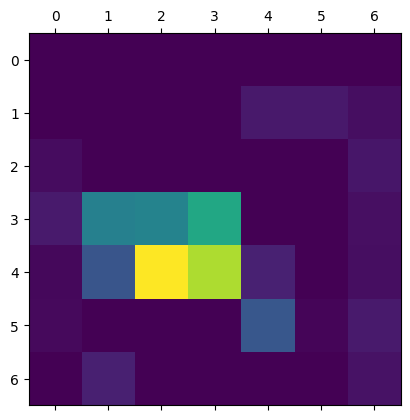

In [175]:
imgpath = "just-bird-data/withBackground/blueTit/(1).jpg"
# unfreeze_layers(model)
heatmat = create_heatmap(model=model, imgpath=imgpath, label=(torch.tensor([0])))

In [176]:
train_model(model, optimizer, train=dataloader_tiny, validation=dataloader_tiny_val)

Epoch 1/5
----------
tensor([0, 5, 3, 2])
tensor([3, 4, 3, 2])
tensor([0, 2, 3, 6])
tensor([0, 6, 6, 2])
Train Loss: 0.0000 Acc: 0.0192
Val Loss: 0.0007 Acc: 0.1538
Epoch time 0m 9s
----------

Epoch 2/5
----------
tensor([2, 3, 0, 6])
tensor([2, 6, 2, 0])
tensor([2, 3, 0, 5])
tensor([4, 3, 6, 3])
Train Loss: 0.0000 Acc: 0.0192
Val Loss: 0.0007 Acc: 0.1538
Epoch time 0m 8s
----------

Epoch 3/5
----------
tensor([3, 0, 3, 3])
tensor([3, 2, 6, 4])
tensor([0, 2, 2, 6])
tensor([2, 0, 5, 6])
Train Loss: 0.0003 Acc: 0.0192
Val Loss: 0.0007 Acc: 0.1538
Epoch time 0m 8s
----------

Epoch 4/5
----------
tensor([3, 6, 0, 2])
tensor([6, 3, 6, 5])
tensor([0, 2, 3, 2])
tensor([3, 0, 2, 4])
Train Loss: 0.0001 Acc: 0.0192
Val Loss: 0.0006 Acc: 0.1538
Epoch time 0m 8s
----------

Epoch 5/5
----------
tensor([2, 4, 2, 0])
tensor([6, 5, 0, 2])
tensor([6, 6, 3, 0])
tensor([2, 3, 3, 3])
Train Loss: 0.0001 Acc: 0.0192
Val Loss: 0.0007 Acc: 0.1538
Epoch time 0m 8s
----------

Training complete in 0m 42s
Be

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

C:\Users\annek\AppData\Local\Temp\ipykernel_39652\2205107314.py:21: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  overlay = to_pil_image(heatmat, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)


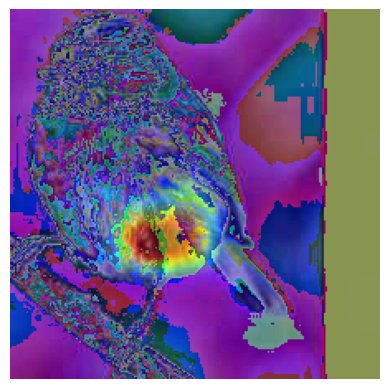

In [177]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL


img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = image_transforms(img)
# Create a figure and plot the first image
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(to_pil_image(img_tensor, mode='RGB'))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmat, mode='F').resize((224,224), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes, 
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.4, interpolation='nearest')

# Show the plot
plt.show()

In [180]:
from PIL import Image

image = Image.open(imgpath).convert('RGB')


In [179]:
visualize_heatmap(heatmat.detach().numpy(), imgpath)

uint32
(224, 224)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'applyColorMap'
> Overload resolution failed:
>  - src data type = uint32 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'
>  - src data type = uint32 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'
